## Kaggle Competition 1
### House Prices - Advanced Regression Techniques
#### Yujia

In [2]:
!python.exe -m pip install --upgrade pip

     ---------------------------------------- 2.1/2.1 MB 3.4 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 22.3.1
    Uninstalling pip-22.3.1:
      Successfully uninstalled pip-22.3.1


In [4]:
!pip list

Package                            Version
---------------------------------- ---------------------
absl-py                            1.0.0
aiohttp                            3.8.3
aiosignal                          1.3.1
alabaster                          0.7.12
altgraph                           0.17
anaconda-client                    1.7.2
anaconda-navigator                 1.10.0
anaconda-project                   0.8.3
argh                               0.26.2
argon2-cffi                        20.1.0
asn1crypto                         1.4.0
astor                              0.8.1
astroid                            2.4.2
astropy                            4.0.2
astunparse                         1.6.3
async-generator                    1.10
async-timeout                      4.0.2
atomicwrites                       1.4.0
attrs                              20.3.0
Automat                            20.2.0
autopep8                           1.5.4
Babel                              


datasets                           2.7.0
decorator                          4.4.2
defusedxml                         0.6.0
diff-match-patch                   20200713
dill                               0.3.6
distributed                        2.30.1
distro                             1.6.0
dm-sonnet                          1.34
dm-tree                            0.1.6
docutils                           0.16
entrypoints                        0.3
et-xmlfile                         1.0.1
fastcache                          1.1.0
filelock                           3.0.12
flake8                             3.8.4
Flask                              1.1.2
flatbuffers                        2.0
fonttools                          4.38.0
frozenlist                         1.3.3
fsspec                             2022.11.0
future                             0.18.2
gast                               0.4.0
gevent                             20.9.0
glob2                              0.7
gmpy2      

In [43]:
from d2l import torch as d2l

In [44]:
import numpy as np
from matplotlib import pyplot as plt
from IPython import display
import random
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import pandas as pd

#### 读数据

In [45]:
train_data = pd.read_csv('./Dataset/train.csv')
test_data = pd.read_csv('./Dataset/test.csv')
train_data.shape

(1460, 81)

In [46]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
all_features.iloc[0:6, [0, 1, 2, 3, -3, -2, -1]]

,MSSubClass,MSZoning,LotFrontage,LotArea,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,2008,WD,Normal
1,20,RL,80.0,9600,2007,WD,Normal
2,60,RL,68.0,11250,2008,WD,Normal
3,70,RL,60.0,9550,2006,WD,Abnorml
4,60,RL,84.0,14260,2008,WD,Normal
5,50,RL,85.0,14115,2009,WD,Normal


#### 预处理数据
1、连续数据的处理（数字型数据处理）

In [47]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()) 
) # 将连续的数字值 转换为 均值为 0 的连续值（标准化）
all_features[numeric_features] = all_features[numeric_features].fillna(0) #因为均值为 0 ，所以所有缺失值可以补为0
all_features.iloc[0:6, [0, 1, 2, 3, -3, -2, -1]]

,MSSubClass,MSZoning,LotFrontage,LotArea,YrSold,SaleType,SaleCondition
0,0.067320,RL,-0.184443,-0.217841,0.157619,WD,Normal
1,-0.873466,RL,0.458096,-0.072032,-0.602858,WD,Normal
2,0.067320,RL,-0.055935,0.137173,0.157619,WD,Normal
3,0.302516,RL,-0.398622,-0.078371,-1.363335,WD,Abnorml
4,0.067320,RL,0.629439,0.518814,0.157619,WD,Normal
5,-0.167877,RL,0.672275,0.500430,0.918095,WD,Normal


2、离散数据的处理（非数字数据处理）

In [48]:
# 使用 pd.get_dummies 处理非数字数据
# 举例： 假设某个特征为 性别：（男， 女）
# 则会处理成： 性别_男 = 1， 性别_女 = 0
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.iloc[0:6, [0, 1, 2, 3, -3, -2, -1]]

,MSSubClass,LotFrontage,LotArea,OverallQual,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,0.067320,-0.184443,-0.217841,0.646073,1,0,0
1,-0.873466,0.458096,-0.072032,-0.063174,1,0,0
2,0.067320,-0.055935,0.137173,0.646073,1,0,0
3,0.302516,-0.398622,-0.078371,0.646073,0,0,0
4,0.067320,0.629439,0.518814,1.355319,1,0,0
5,-0.167877,0.672275,0.500430,-0.772420,1,0,0


In [49]:
all_features.shape

(2919, 331)

In [95]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

In [98]:
"""
 我这里写的 class MyDataset 是 李沐 d2l.load_array()的手动实现，原理一致
 可以直接调用d2l.load_array()简便直接得到可以迭代的 train_iter
 需要查看源代码可以输入以下代码：
     d2l.load_array??
     d2l.data.TensorDataset??
"""
# class MyDataset(Dataset):
#     def __init__(self, features, labels):
#         self.x = features
#         self.y = labels
#         self.len = len(self.x)
#     def __getitem__(self, index):
#         return self.x[index], self.y[index]
#     def __len__(self):
#         return self.len
# train_set = MyDataset(train_features, train_labels)
# train_iter = DataLoader(
#     dataset = train_set,
#     batch_size = 64,
#     shuffle = True,
#     drop_last = True
# )
# for X, y in train_iter:
#     print(X.shape)
#     break

'\n 我这里写的 class MyDataset 是 李沐 d2l.load_array()的手动实现，原理一致\n 可以直接调用d2l.load_array()简便直接得到可以迭代的 train_iter\n 需要查看源代码可以输入以下代码：\n     d2l.load_array??\n     d2l.data.TensorDataset??\n'

#### 网络定义

In [77]:
model_name = 'MLP'
loss = torch.nn.MSELoss()
in_features = train_features.shape[1]
class BaseLine_Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__() #从这里往上的内容就是照抄，每次都一样的
        self.linear_net = nn.Sequential(
            nn.Linear(in_features,1)
        )
    def forward(self,x):
        x = self.linear_net(x)
        return x
    
class MLP_Net(nn.Module):
    def __init__(self):
        super(MLP_Net, self).__init__()
        self.hidden_layer = nn.Sequential(
            nn.Linear(in_features, in_features),
            nn.ReLU()
        )
        self.linear_layer = nn.Sequential(
            nn.Linear(in_features, 1)
        )
    def forward(self, x):
        x = self.hidden_layer(x)
        y = self.linear_layer(x)
        return y
    
def get_model(name):
    if (name=='baseline'):
        model = BaseLine_Net()
    if (name=='MLP'):
        model = MLP_Net()
    return model

In [78]:
def NetInit(m):
    if type(m) == nn.Linear:
        torch.nn.init.normal_(m.weight, mean=0, std=0.01)

In [79]:
# num_epochs = 100
# lr = 0.1
# wd = 0
# loss = torch.nn.MSELoss()

<h3 style="color:red;"> .item()</h3>
<p>.item()是 张量 的自带函数，用于将 单个 张量转换为python 数值（一个数）</p>

In [80]:
def log_rmse(model, features, labels):
    clipped_preds = torch.clamp(model(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

In [81]:
def train(model, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
#     train_iter = DataLoader(
#         dataset = MyDataset(train_features, train_labels),
#         batch_size = 64,
#         shuffle = True,
#         drop_last = True
#     )
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    opt = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    for epoch in range(1, num_epochs+1):
        if(epoch == 100):
            print('done')
        for (X, y) in train_iter:
            opt.zero_grad()
            l = loss(model(X), y)
            l.backward()
            opt.step()
        train_ls.append(log_rmse(model, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(model, test_features, test_labels))
    return train_ls, test_ls

In [82]:
def get_k_fold_data(k, i, X, y):
    assert k > 1  # 断言，结果为false会触发异常
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j+1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [83]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        model = get_model(model_name)
        data = get_k_fold_data(k, i, X_train, y_train)
        train_ls, valid_ls = train(model, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i==0:
            d2l.plot(list(range(1, num_epochs+1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i+1}, 训练log_rmse{float(train_ls[-1]):f},'
                  f'验证log_rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

done
折1, 训练log_rmse0.035897,验证log_rmse0.139247
done
折2, 训练log_rmse0.021630,验证log_rmse0.169193
done
折3, 训练log_rmse0.028252,验证log_rmse0.161367
done
折4, 训练log_rmse0.039500,验证log_rmse0.146199
done
折5, 训练log_rmse0.029988,验证log_rmse0.162289
5-折验证, 平均训练log_rmse0.031053,平均验证log_rmse0.155659


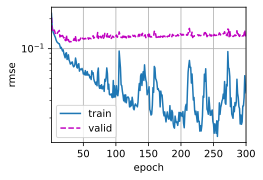

In [99]:
k, num_epochs, lr, weight_decay, batch_size = 5, 300, 0.5, 2, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print(f'{k}-折验证, 平均训练log_rmse{float(train_l):f},'
      f'平均验证log_rmse{float(valid_l):f}')

<h2 style="color:red;"> 关于 k折交叉验证 </h2>
k_fold 函数是k折交叉验证的函数：其道理是先将训练集划分为 训练集和验证集，训练多次（k次），每次训练的训练集和验证集都不同，目的是找到合适的超参数，其实就是调参的过程。当验证集的误差（泛化误差）和训练集的误差（训练误差）相差不大时，可以认为找到了合适的超参数，此时可以使用这个超参数，并用全部的训练集来做训练，即是后面的 train_and_pred函数。道理是什么呢？如果不加这个k折验证，假设一上来就在全部训练集上进行训练，训练误差到了令人满意的数值，此时并不意味着这个模型和其超参数在测试集上一样表现优秀，很有可能出现差别较大的情况，而此时就相当于浪费了数据集，因此需要使用k折验证<br>
    ------ 2023.2.23 时候的理解 yujia

In [100]:
def train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size):
    model = get_model(model_name)
    train_ls, _ = train(model, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs+1), [train_ls], xlabel='epoch', ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse: {float(train_ls[-1]):f}')
    preds = model(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

done
训练log rmse: 0.023828


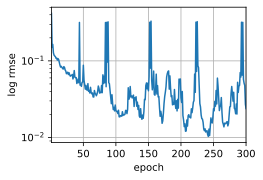

In [101]:
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)